# Prediksi Credit Dengan Deep Learning

Dataset : 

https://www.kaggle.com/competitions/GiveMeSomeCredit/data

# Menyiapkan Kredential Akun Kaggle

In [ ]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dan Menyiapkan Dataset

In [ ]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle competitions download -c GiveMeSomeCredit

  0% 0.00/5.16M [00:00<?, ?B/s]
100% 5.16M/5.16M [00:00<00:00, 95.8MB/s]


In [ ]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip /content/GiveMeSomeCredit.zip

Archive:  /content/GiveMeSomeCredit.zip
  inflating: Data Dictionary.xls     
  inflating: cs-test.csv             
  inflating: cs-training.csv         
  inflating: sampleEntry.csv         


# Import Library dan Package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import random
from scipy import stats

warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import PCA

In [ ]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
from keras import models
from keras import layers

# Load Training Data

# No. 1 Lakukan Load pada data " cs-training.csv "

Clue : lakukan kredential akun kaggle untuk mendapatkan dataset tanpa mendownload nya kemudian copy path data yang ingin di load pada direktori file google colaboratory

In [ ]:
data_  = pd.read_csv('/content/cs-training.csv')

In [ ]:
data_.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

# Check the percentage of Defaults and Non-Defaults

0    93.316
1     6.684
Name: SeriousDlqin2yrs, dtype: float64


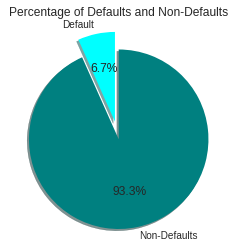

In [ ]:
print(data_['SeriousDlqin2yrs'].value_counts()/data_.shape[0] *100)

## Pie Chart
labels = 'Default', 'Non-Defaults'
sizes = [6.684, 93.316]
explode = (0.2, 0)
cols    = ['#00FFFF', '#008080']

fig = plt.figure(figsize = (4,4))
plt.pie(sizes, explode=explode, colors = cols, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt. title("Percentage of Defaults and Non-Defaults")
plt.show()

# EDA

## Missing Value


In [ ]:
def missing_vals(data_):
    miss_     = data_.isnull().sum()
    miss_pct  = data_.isnull().sum()/data_.shape[0]
    
    miss_pct  = pd.concat([miss_, miss_pct], axis =1)
    miss_pct.reset_index(inplace=True)
    miss_cols = miss_pct.rename(columns={'index':'Column Name', 0:'Missings', 1:'Missing_pct'})
    
    miss_cols = miss_cols[miss_cols.iloc[:,1]!=0].sort_values('Missing_pct', ascending=False).round(1)
    miss_cols.reset_index(inplace=True, drop=True)
    
    return miss_cols 

In [ ]:
miss = missing_vals(data_)
miss

,Column Name,Missings,Missing_pct
0,MonthlyIncome,29731,0.2
1,NumberOfDependents,3924,0.0


Kesimpulan: Kami melihat bahwa ada sangat sedikit nilai yang hilang di dua kolom. Kemudian juga, kita akan mengganti nilai yang hilang dengan mean. Perawatan nilai yang hilang adalah area lain yang memiliki begitu banyak pilihan tetapi yang tercepat adalah menggantinya dengan rata-rata atau median (ketika persentase yang hilang benar-benar lebih kecil)

Statistik deskriptif

Kita mulai dengan statistik Deskriptif dengan memeriksa statistik dasar variabel. Kemudian kita mulai mengembangkan histogram untuk semua variabel. Ini akan membantu kita memahami distribusi masing-masing variabel

# No. 2 Tambilkan deskripsi dari data_

In [ ]:
data_.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [ ]:
cols = list(data_.columns)
cols = cols[1:]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c']

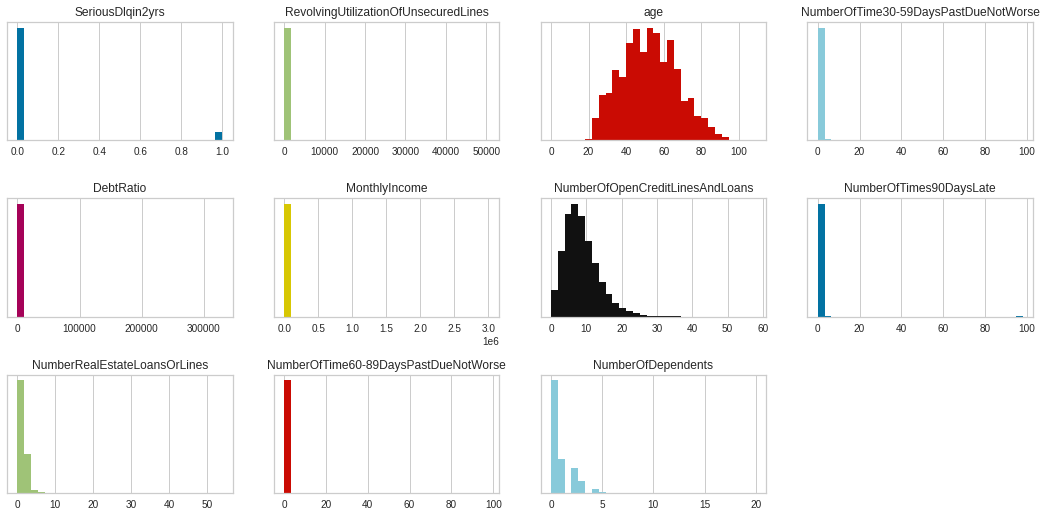

In [ ]:
# Plot
fig = plt.figure(figsize=(15, 12))
for i in range(0, len(cols)):
    plt.subplot(5, 4, i+1)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)

    plt.hist(data_[cols[i]], bins=30, color=colors[i])
    plt.title(cols[i])

plt.tight_layout()

# Isi missing value dengan mean

# No. 3 

Isi missing value dengan mean
Clue: gunakan transform lambda kemudian isi fillna dengan mean

In [ ]:
df = data_.copy()
df['MonthlyIncome'] =df['MonthlyIncome'].transform(lambda x: x.fillna(x.mean()))
df['NumberOfDependents'] =df['NumberOfDependents'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# Cek ulang missing value
miss = missing_vals(df)
miss

,Column Name,Missings,Missing_pct


Seperti yang kita lihat bahwa tidak ada nilai nol yang tersisa. Banyak algoritme Pembelajaran Mesin mengambil nilai yang hilang dalam analisisnya, tetapi selalu merupakan strategi yang lebih baik untuk menanganinya sebelum mencapai tahap pemodelan.

Ada beberapa contoh ketika Anda tidak dapat mengobatinya:

- Nilai yang hilang menghilangkan sekitar 30-50% pengamatan di mana Anda tidak dapat menghapusnya

- Dalam kasus di atas, Anda bahkan tidak dapat memperlakukannya dengan mean, median sebagai variabel dengan begitu banyak nilai serupa tidak membawa banyak varians dalam variabel

# Default and Non-Default Visualization

Kami akan mencoba memvisualisasikan Default dan Non-Defaults pada kerangka kerja 2axis dan melihat seberapa banyak tumpang tindih yang mereka miliki. Untuk ini kita akan menggunakan PCA untuk mendapatkan dua komponen utama yang merupakan kombinasi dari semua variabel. Ini akan membantu kami memahami distribusi Default dan Non-Default


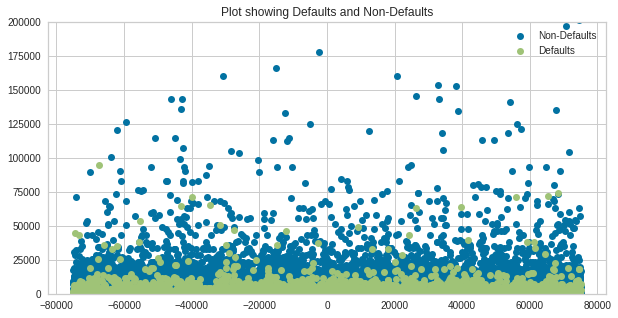

In [ ]:
random.seed(32)
pca = PCA(n_components = 2)
pca.fit(df)

scores = pca.transform(df)

x,y = scores[:,0] , scores[:,1]
df_ = pd.DataFrame({'x': x, 'y':y, 'clusters':df['SeriousDlqin2yrs']})
grouping_ = df_.groupby('clusters')


fig, ax = plt.subplots(figsize=(10, 5))
names = {0: 'Non-Defaults', 
         1: 'Defaults'}

for name, grp in grouping_:
    ax.plot(grp.x, grp.y, marker='o', label = names[name], linestyle='')
    ax.set_aspect('auto')
    ax.set_ylim([0,200000])     ### I have just kept a upper cap on the axis to see the distribution of them
    
ax.legend()
plt.title('Plot showing Defaults and Non-Defaults')
plt.show()

Sekarang melakukan One-Hot Encoding

Satu pengkodean panas adalah proses di mana variabel kategoris diubah menjadi bentuk yang dapat disediakan untuk algoritma ML untuk melakukan pekerjaan yang lebih baik dalam prediksi

Beberapa algoritma dapat bekerja dengan data kategorikal secara langsung. Misalnya, pohon keputusan dapat dipelajari secara langsung dari data kategorikal tanpa memerlukan transformasi data (ini tergantung pada implementasi spesifik). Banyak algoritme pembelajaran mesin tidak dapat beroperasi pada data label secara langsung. Mereka membutuhkan semua variabel input dan variabel output menjadi numerik. Secara umum, ini sebagian besar merupakan kendala implementasi algoritma pembelajaran mesin yang efisien daripada batasan keras pada algoritma itu sendiri. Ini berarti bahwa data kategoris harus diubah ke dalam bentuk numerik.


# No. 4 
Lakukan One Hot Encoding menggunakan get dummies, kemudian tampilan head dari data tersebut

In [ ]:
df = pd.get_dummies(df)
df = df[[c for c in df if c not in ['SeriousDlqin2yrs']]+['SeriousDlqin2yrs']]
df = df.drop(['Unnamed: 0'], axis=1)

In [ ]:
df.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0


# Memeriksa korelasi

Kami akan memeriksa dua jenis korelasi:

- Korelasi dengan variabel terikat untuk memeriksa variabel mana yang berkorelasi lebih baik dengan variabel terikat
- Korelasi antara variabel yang berbeda yang pada dasarnya memeriksa mutli-kolinearitas

Ini adalah langkah di mana kami mengurangi variabel dan sebagai bagian dari bagian rekayasa fitur. Dalam kasus kami, kami memiliki jumlah variabel yang lebih kecil tetapi itu hanya kasus penggunaan. Rekayasa Fitur benar-benar dapat merusak atau membuat model.

In [ ]:
correlations = pd.DataFrame(df.corr()['SeriousDlqin2yrs'].sort_values())
correlations = correlations.rename(columns = {'SeriousDlqin2yrs':'Correlation value'})

In [ ]:
correlations

,Correlation value
age,-0.115386
NumberOfOpenCreditLinesAndLoans,-0.029669
MonthlyIncome,-0.018002
DebtRatio,-0.007602
NumberRealEstateLoansOrLines,-0.007038
RevolvingUtilizationOfUnsecuredLines,-0.001802
NumberOfDependents,0.045621
NumberOfTime60-89DaysPastDueNotWorse,0.102261
NumberOfTimes90DaysLate,0.117175
NumberOfTime30-59DaysPastDueNotWorse,0.125587


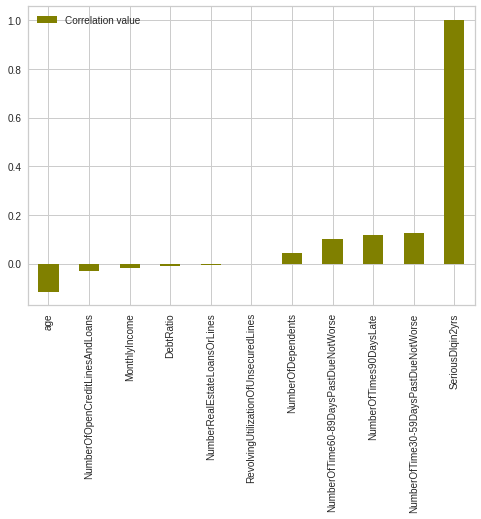

In [ ]:
correlations.plot(kind="bar", color="olive")

Kami melihat bahwa nilai korelasi sedikit kurang di semua variabel. Tidak ada variabel yang memiliki korelasi lebih dari 0,5. Variabel NumberOfTime30-59DaysPastDueNotWorse memiliki korelasi tertinggi dengan variabel dependen

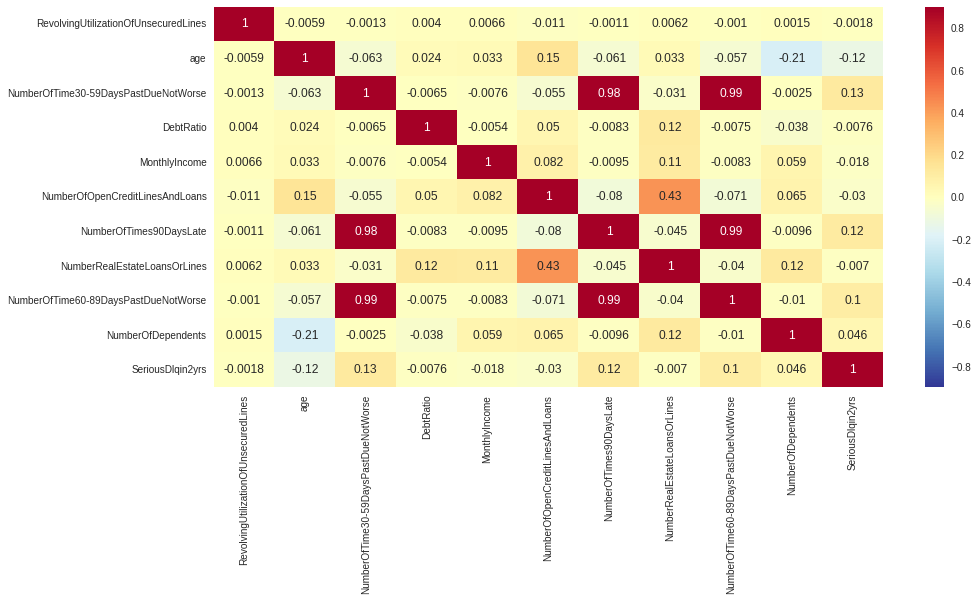

In [ ]:
# Korelasi dengan Heatmap
corr_ = df.corr()
fig= plt.figure(figsize=(15,7))
sns.heatmap(corr_, cmap = plt.cm.RdYlBu_r, vmin = -0.9, annot = True, vmax = 0.9)

Hasil : Kita melihat variabel tersebut; NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate & NumberOfTime30-59DaysPastDueNotWorse memiliki korelasi yang tinggi di antara mereka sendiri. Untuk mengatasi masalah multikolinieritas, kita dapat menghapus dua variabel dan hanya menyimpan salah satunya. Ini sekali lagi merupakan bagian dari rekayasa fitur.

Sekarang, mengapa saya memilih variabel NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate untuk dihapus sebagai pertama variabel NumberofTime90DaysLate adalah variabel terkait koleksi yang seperti banyak digunakan ketika seseorang tidak mampu membayar kembali pinjaman dan koleksi (tim yang mengumpulkan kembali uang) mencapai pelanggan untuk memaksanya membayar atau tindakan hukum diambil terhadapnya

In [ ]:
# Kita drop variabel nya
df = df.drop(['NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'], axis=1)

# Modelling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['SeriousDlqin2yrs'], axis=1), df['SeriousDlqin2yrs'], test_size=0.2,random_state = 72)

## Oversampling dan Undersampling

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
smt = SMOTE(random_state = 0) 
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 8036
Before OverSampling, counts of label '0': 111964 

After OverSampling, the shape of train_X: (223928, 8)
After OverSampling, the shape of train_y: (223928,) 

After OverSampling, counts of label '1': 111964
After OverSampling, counts of label '0': 111964


# Fungsi untuk mengukur kecocokan Model

Di bawah ini adalah fungsi yang akan kita gunakan untuk mengukur kebugaran model. Fungsi ini berisi metrik seperti Akurasi, Presisi, Recall, dan Skor F1. Itu juga menghitung GINI dan AUC model dan memberi kami Pentingnya Fitur sesuai model masing-masing (hanya jika algoritme Pembelajaran Mesin tertentu memungkinkan untuk melakukannya)

In [ ]:
def model_fit_reports(algo,X_,y_,performCV=True,printFeatureImportance=True, cv_folds=5):
    
    #Accuracy, Precision, Recall, F1 Score
    pred = algo.predict(X_)
    accu = accuracy_score(y_, pred)
    f1_  = f1_score(y_, pred)
    rec  = recall_score(y_, pred)
    prec = precision_score(y_, pred)

    
    #GINI & AUC
    fpr, tpr, thresholds = roc_curve(y_, pred)
    roc_auc = auc(fpr, tpr)
    Gini   = 2*roc_auc - 1   
    labels  = ['Accuracy','F1 Score', 'Recall', 'Precision', 'Gini', 'AUC']
    values  = [accu,f1_,rec,prec,Gini,roc_auc]
    
    all_    = pd.Series(values,labels)  
    print(all_)
    all_.plot(kind='bar', title='Model Fit Report')   


    if performCV:
        cv_score = cross_val_score(algo, X_, y_, cv=cv_folds, scoring='roc_auc')
        GINI     = 2 * cv_score -1
        print("AUC : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        print("GINI : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(GINI),np.std(GINI),np.min(GINI),np.max(GINI)))

    cols = list(X_.columns)
    if printFeatureImportance:
        feat_imp = pd.Series(algo.feature_importances_, cols).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')    
    
    return all_

Mengembangkan model dengan berbagai Algoritma

Kami akan mengembangkan model kami dengan berbagai algoritma ML dan membandingkannya dengan Alogitma Tradisional. Juga, meskipun tampaknya mudah untuk menyetel algo ML ini, tetapi mengoptimalkan dan menyetel alogitma tersebut cukup sulit. Dalam pengklasifikasi, kami harus menggunakan beberapa metrik yang menjadi dasar kami dapat menyesuaikan dan meningkatkan klasifikasi kami. Metrik ini adalah:

- Precision
- Recall
- F1 Score
- GINI
- AUC

Kami juga akan menjalankan CV untuk memeriksa apakah hasil kami konsisten saat diukur pada metrik seperti GINI atau AUC

# Logistic Regresssion

In [ ]:
regressor = LogisticRegression(random_state =2, solver='sag', max_iter = 10**2)
regressor.fit(X_train_res, y_train_res)

LogisticRegression(random_state=2, solver='sag')

Accuracy     0.932992
F1 Score     0.000249
Recall       0.000124
Precision    0.142857
Gini         0.000071
AUC          0.500035
dtype: float64
AUC : Mean - 0.575171 | Std - 0.002572142 | Min - 0.5704092 | Max - 0.5775605
GINI : Mean - 0.1503419 | Std - 0.005144285 | Min - 0.1408184 | Max - 0.155121


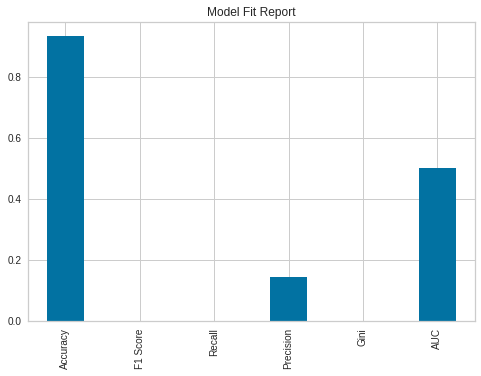

In [ ]:
# Hasil Train Data
train = model_fit_reports(algo =regressor ,X_ = X_train,y_ = y_train, performCV=True, printFeatureImportance=False, cv_folds=5)

Accuracy     0.933667
F1 Score     0.001004
Recall       0.000503
Precision    0.500000
Gini         0.000467
AUC          0.500233
dtype: float64
AUC : Mean - 0.5754241 | Std - 0.009694285 | Min - 0.5609097 | Max - 0.5864381
GINI : Mean - 0.1508481 | Std - 0.01938857 | Min - 0.1218194 | Max - 0.1728762


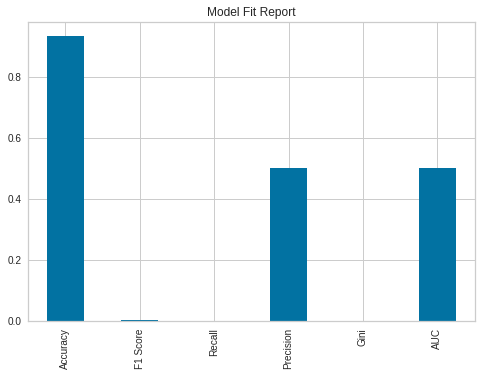

In [ ]:
# Hasil Test Data
test  = model_fit_reports(algo =regressor ,X_ = X_test,y_ = y_test, performCV=True, printFeatureImportance=False, cv_folds=5)

# Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=8, n_estimators=500)
rfc.fit(X_train_res, y_train_res)

RandomForestClassifier(n_estimators=500, random_state=8)

Accuracy     0.999083
F1 Score     0.993191
Recall       0.998382
Precision    0.988054
Gini         0.997516
AUC          0.998758
dtype: float64
AUC : Mean - 0.8207226 | Std - 0.006535456 | Min - 0.8088928 | Max - 0.828322
GINI : Mean - 0.6414452 | Std - 0.01307091 | Min - 0.6177855 | Max - 0.6566441


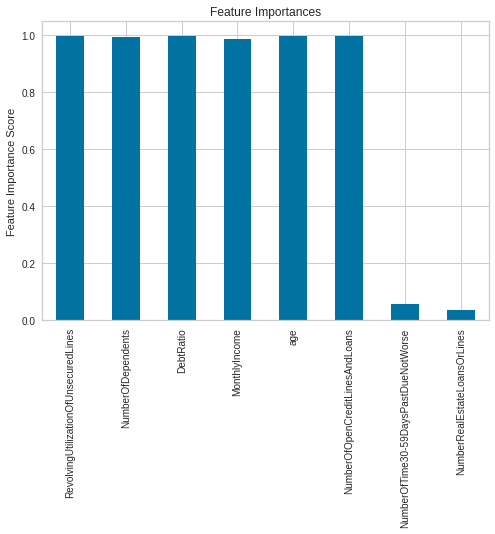

In [ ]:
# Hasil Train Data
train = model_fit_reports(algo =rfc ,X_ = X_train,y_ = y_train, performCV=True, printFeatureImportance=True, cv_folds=5)

Accuracy     0.881833
F1 Score     0.301753
Recall       0.384925
Precision    0.248137
Gini         0.302061
AUC          0.651031
dtype: float64
AUC : Mean - 0.8099214 | Std - 0.005295745 | Min - 0.8044345 | Max - 0.8176102
GINI : Mean - 0.6198429 | Std - 0.01059149 | Min - 0.6088691 | Max - 0.6352205


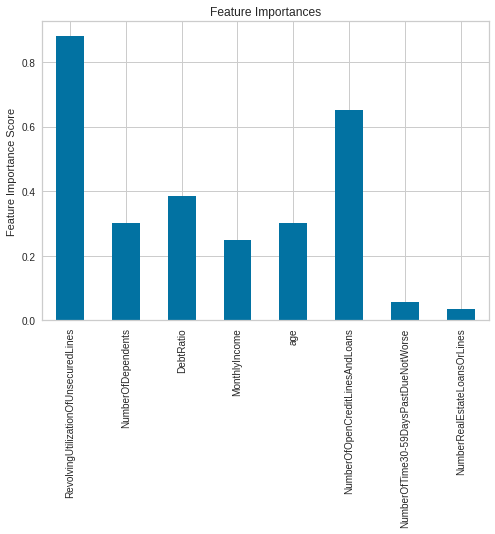

In [ ]:
# Hasil Test Data
test = model_fit_reports(algo =rfc ,X_ = X_test,y_ = y_test, performCV=True, printFeatureImportance=True, cv_folds=5)

# Gradient Boosting

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_res, y_train_res)

GradientBoostingClassifier()

Accuracy     0.850300
F1 Score     0.317788
Recall       0.520657
Precision    0.228684
Gini         0.394617
AUC          0.697308
dtype: float64
AUC : Mean - 0.8383914 | Std - 0.004888249 | Min - 0.8296787 | Max - 0.8430296
GINI : Mean - 0.6767828 | Std - 0.009776499 | Min - 0.6593574 | Max - 0.6860592


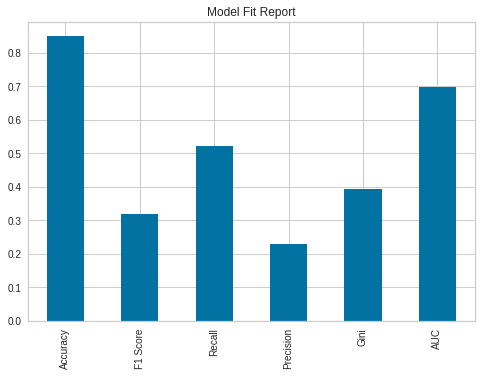

In [ ]:
# Hasil Train Data
train = model_fit_reports(algo =gbc ,X_ = X_train,y_ = y_train, performCV=True, printFeatureImportance=False, cv_folds=5)

Accuracy     0.848767
F1 Score     0.311010
Recall       0.514573
Precision    0.222851
Gini         0.387083
AUC          0.693541
dtype: float64
AUC : Mean - 0.8290124 | Std - 0.007006686 | Min - 0.8201903 | Max - 0.8397376
GINI : Mean - 0.6580248 | Std - 0.01401337 | Min - 0.6403806 | Max - 0.6794751


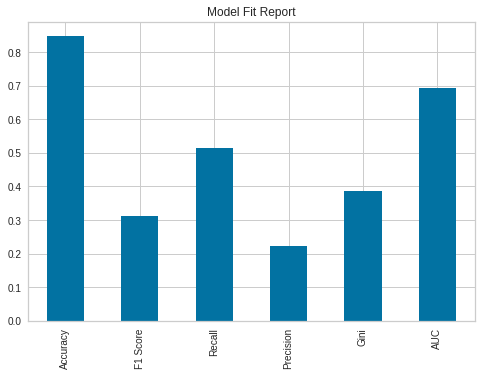

In [ ]:
# Hasil Test Data
test = model_fit_reports(algo =gbc ,X_ = X_test,y_ = y_test, performCV=True, printFeatureImportance=False, cv_folds=5)

Seperti yang kita lihat GINI data pengujian kami bahkan kurang dari 50%, kami harus menyesuaikannya sehingga kami mencapai GINI yang jauh lebih baik pada data Pengujian kami
Menyetel parameter Peningkat Gradien

Kami akan menyetel berbagai hyperparameter Gradient Boosting untuk meningkatkan hasil pemotongan pertama kami. 

- n_estimators : Jumlah pohon sekuensial yang akan dimodelkan. Meskipun GBM cukup kuat pada jumlah pohon yang lebih tinggi tetapi masih bisa overfit pada suatu titik. Oleh karena itu, ini harus disetel menggunakan CV untuk tingkat pembelajaran tertentu.

- max_depth : Ini adalah jumlah kedalaman maksimum pohon. Digunakan untuk mengontrol over-fitting karena kedalaman yang lebih tinggi akan memungkinkan model untuk mempelajari hubungan yang sangat spesifik untuk sampel tertentu

- min_samples_split : Ini adalah jumlah minimum sampel (atau pengamatan) yang diperlukan dalam sebuah simpul untuk dipertimbangkan untuk dipecah.

- min_samples_leaf : Ini adalah sampel minimum (baris atau pengamatan) yang diperlukan dalam simpul terminal atau daun

- max_features : Jumlah fitur yang harus dipertimbangkan saat mencari pemisahan terbaik. Pemilihan acak dilakukan ketika kami memperbaiki jumlah fitur untuk menghindari bias. Nilai yang lebih tinggi dapat menyebabkan over-fitting

- subsampel : Fraksi pengamatan yang akan dipilih untuk setiap pohon. Pemilihan dilakukan dengan cara random sampling.

# Tuning n-estimators

In [ ]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1    = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                                                               param_grid = param_test1, scoring='roc_auc',
                                                               n_jobs=4, cv=5)

gsearch1.fit(X_train_res,y_train_res)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 81, 10)},
             scoring='roc_auc')

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.9468096665177905)

# Tuning Max_depth & min_samples_split

In [ ]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,400,600)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

gsearch2.fit(X_train_res,y_train_res)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 400, 600)},
             scoring='roc_auc')

In [ ]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 15, 'min_samples_split': 200}, 0.9616368331323581)

# Tuning min_samples_split & min_samples_leaf

In [ ]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}

gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train_res,y_train_res)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15,
                                                  max_features='sqrt',
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'min_samples_leaf': range(30, 71, 10),
                         'min_samples_split': range(1000, 2100, 200)},
             scoring='roc_auc')

In [ ]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 30, 'min_samples_split': 1000}, 0.9532280146187906)

# Tuning max_features

In [ ]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15, min_samples_split=1000, min_samples_leaf=30, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train_res,y_train_res)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15,
                                                  min_samples_leaf=30,
                                                  min_samples_split=1000,
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'max_features': range(7, 20, 2)},
             scoring='roc_auc')

In [ ]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 7}, 0.9555610657588206)

# Tuning Subsample

In [ ]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth= 15, min_samples_split= 1000, min_samples_leaf=30,max_features=7, random_state = 10),
param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train_res,y_train_res)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15, max_features=7,
                                                  min_samples_leaf=30,
                                                  min_samples_split=1000,
                                                  n_estimators=80,
                                                  random_state=10),
             n_jobs=4,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
             scoring='roc_auc')

In [ ]:
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.9}, 0.9563722420237208)

# Combining all the tuned parameter values and runnning them as a whole

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=80, max_depth= 15, min_samples_split= 1000, min_samples_leaf=30,subsample=0.9,max_features=7)
gbc.fit(X_train_res, y_train_res)

GradientBoostingClassifier(max_depth=15, max_features=7, min_samples_leaf=30,
                           min_samples_split=1000, n_estimators=80,
                           subsample=0.9)

Accuracy     0.892867
F1 Score     0.391576
Recall       0.514808
Precision    0.315946
Gini         0.434809
AUC          0.717405
dtype: float64
AUC : Mean - 0.835296 | Std - 0.005100484 | Min - 0.8261637 | Max - 0.8398019
GINI : Mean - 0.670592 | Std - 0.01020097 | Min - 0.6523273 | Max - 0.6796038


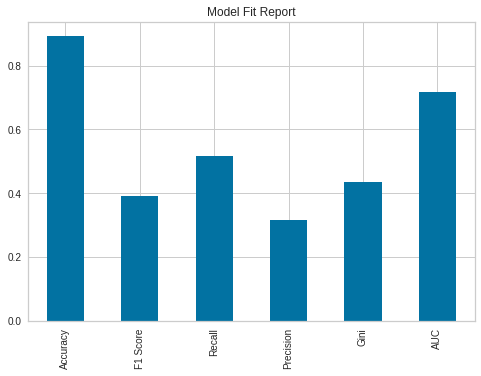

In [ ]:
train = model_fit_reports(gbc,X_train,y_train,performCV=True,printFeatureImportance=False, cv_folds=5)

Accuracy     0.873333
F1 Score     0.303519
Recall       0.416080
Precision    0.238892
Gini         0.321900
AUC          0.660950
dtype: float64
AUC : Mean - 0.8225581 | Std - 0.00656653 | Min - 0.8131866 | Max - 0.8326784
GINI : Mean - 0.6451162 | Std - 0.01313306 | Min - 0.6263731 | Max - 0.6653569


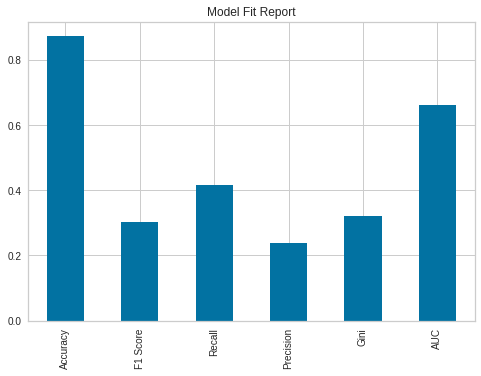

In [ ]:
test = model_fit_reports(gbc,X_test,y_test,performCV=True,printFeatureImportance=False, cv_folds=5)

# XGBoost

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.001,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 reg_alpha = 0.1,
 scale_pos_weight=1,
 seed=27)

In [ ]:
xgb1.fit(X_train_res, y_train_res)

XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9,
              n_estimators=1000, nthread=4, reg_alpha=0.1, seed=27,
              subsample=0.8)

Accuracy     0.866942
F1 Score     0.346445
Recall       0.526630
Precision    0.258127
Gini         0.417997
AUC          0.708999
dtype: float64
AUC : Mean - 0.8377708 | Std - 0.005663738 | Min - 0.8271766 | Max - 0.8430717
GINI : Mean - 0.6755416 | Std - 0.01132748 | Min - 0.6543532 | Max - 0.6861433


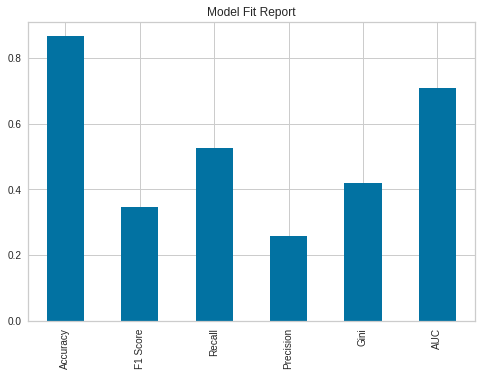

In [ ]:
train = model_fit_reports(xgb1,X_train,y_train,performCV=True,printFeatureImportance=False, cv_folds=5)

Accuracy     0.859167
F1 Score     0.316011
Recall       0.490452
Precision    0.233102
Gini         0.375815
AUC          0.687907
dtype: float64
AUC : Mean - 0.8289751 | Std - 0.006982516 | Min - 0.8192262 | Max - 0.8401845
GINI : Mean - 0.6579501 | Std - 0.01396503 | Min - 0.6384524 | Max - 0.680369


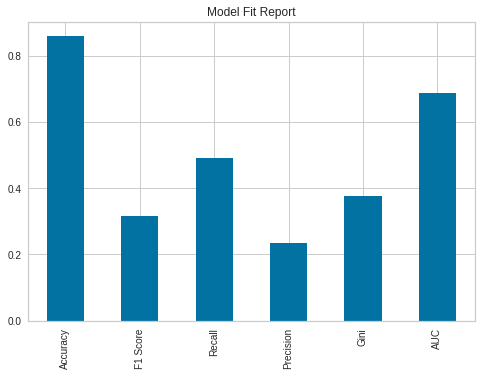

In [ ]:
test = model_fit_reports(xgb1,X_test,y_test,performCV=True,printFeatureImportance=False, cv_folds=5)

# Tuning XGboost

Tuning hyperparameter XgBoost:

- max_depth: Kedalaman maksimum pohon
- min_child_weight: Ini adalah jumlah bobot minimum dari semua pengamatan yang diperlukan pada seorang anak
- gamma: Sebuah node dipecah hanya ketika hasil split memberikan pengurangan positif pada fungsi kerugian. Gamma menentukan pengurangan kerugian minimum yang diperlukan untuk membuat split
- subsampel: Menunjukkan fraksi pengamatan menjadi sampel acak untuk setiap pohon

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     n_estimators=140, nthread=4, seed=27,
                                     subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.9592374507898859)

In [ ]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     min_child_weight=2, n_estimators=140,
                                     nthread=4, seed=27, subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
             scoring='roc_auc')

In [ ]:
gsearch2.best_params_, gsearch2.best_score_



({'max_depth': 6, 'min_child_weight': 5}, 0.9493137746571815)

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=9,
                                     min_child_weight=2, n_estimators=140,
                                     nthread=4, seed=27, subsample=0.8),
             n_jobs=4, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='roc_auc')

In [ ]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.9586734905149982)

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)

gsearch6.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, gamma=0.2,
                                     max_depth=5, n_estimators=177, nthread=4,
                                     seed=27, subsample=0.8),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='roc_auc')

In [ ]:
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1}, 0.9477897569345833)

# Deep Learning

In [ ]:
n_inputs = X_train_res.shape[1]

model = models.Sequential()
model.add(layers.Dense(16, activation ='relu', input_shape =(n_inputs, )))
model.add(layers.Dense(32,activation = 'relu'))
model.add(layers.Dense(1,activation ='sigmoid'))

In [ ]:
model.compile(optimizer = 'rmsprop',
             loss= 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train_res,
                   y_train_res,
                   epochs=150,
                   batch_size=512,
                   validation_data=(X_test,y_test))

Epoch 1/150
438/438 [==============================] - 2s 3ms/step - loss: 10.9593 - accuracy: 0.5041 - val_loss: 1.7909 - val_accuracy: 0.1839
Epoch 2/150
438/438 [==============================] - 1s 2ms/step - loss: 8.4831 - accuracy: 0.5078 - val_loss: 5.6677 - val_accuracy: 0.0973
Epoch 3/150
438/438 [==============================] - 1s 2ms/step - loss: 7.5944 - accuracy: 0.5074 - val_loss: 9.2457 - val_accuracy: 0.0843
Epoch 4/150
438/438 [==============================] - 1s 2ms/step - loss: 6.9463 - accuracy: 0.5090 - val_loss: 1.3107 - val_accuracy: 0.9340
Epoch 5/150
438/438 [==============================] - 1s 2ms/step - loss: 6.3466 - accuracy: 0.5102 - val_loss: 1.7548 - val_accuracy: 0.9340
Epoch 6/150
438/438 [==============================] - 1s 2ms/step - loss: 5.7798 - accuracy: 0.5118 - val_loss: 10.4298 - val_accuracy: 0.0728
Epoch 7/150
438/438 [==============================] - 1s 2ms/step - loss: 5.1578 - accuracy: 0.5135 - val_loss: 1.0964 - val_accuracy: 0.93

In [ ]:
score = model.evaluate(X_test, y_test)

938/938 [==============================] - 1s 1ms/step - loss: 0.4703 - accuracy: 0.7694


In [ ]:
#GINI & AUC 
pred  = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print("The AUC of the Test model is ", roc_auc)
Gini   = 2*roc_auc - 1
print("The Gini of the Test model is ", Gini)

The AUC of the Test model is  0.8052609889863456
The Gini of the Test model is  0.6105219779726911


# Perbandingan Kurva ROC Pada Data Test

In [ ]:
log_pred = regressor.predict(X_test)
rfc_pred = rfc.predict(X_test)
gbm_pred = gbc.predict(X_test)
xgb_pred = xgb1.predict(X_test)
deepl_pred = model.predict(X_test)

In [ ]:
log_fpr, log_tpr, log_threshold   = roc_curve(y_test, log_pred)
rfc_fpr, rfc_tpr, rfc_threshold   = roc_curve(y_test, rfc_pred)
gbm_fpr, gbm_tpr, gbm_threshold   = roc_curve(y_test, gbm_pred)
xgb_fpr, xgb_tpr, xgb_threshold   = roc_curve(y_test, xgb_pred)
deepl_fpr, deepl_tpr, deepl_threshold   = roc_curve(y_test, deepl_pred)

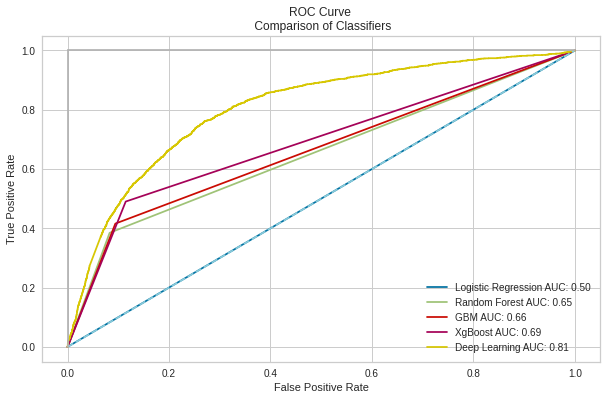

In [ ]:
# Plot ROC curves
fig  = plt.figure(figsize=(10,6))
plt.title('ROC Curve \n Comparison of Classifiers')
plt.plot(log_fpr, log_tpr, label ='Logistic Regression AUC: {:.2f}'.format(roc_auc_score(y_test, log_pred)))
plt.plot(rfc_fpr, rfc_tpr, label ='Random Forest AUC: {:.2f}'.format(roc_auc_score(y_test, rfc_pred)))
plt.plot(gbm_fpr, gbm_tpr, label ='GBM AUC: {:.2f}'.format(roc_auc_score(y_test, gbm_pred)))
plt.plot(xgb_fpr, xgb_tpr, label ='XgBoost AUC: {:.2f}'.format(roc_auc_score(y_test, xgb_pred)))
plt.plot(deepl_fpr, deepl_tpr, label ='Deep Learning AUC: {:.2f}'.format(roc_auc_score(y_test, deepl_pred)))

plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

Hasil : Seperti yang kita lihat dengan jelas bahwa model Deep Learning bekerja paling baik pada data Test. Ini memiliki skor AUC sekitar 81% yang merupakan skor classifer yang baik untuk versi potongan pertama. Kami pasti dapat meningkatkan banyak hal ini dengan menyetel model keras kami

# Membuat Skor dari Probabilitas

Selanjutnya yang kita miliki adalah bagaimana kita mengkonsumsi probabilitas ini. Karena, memprediksi default berada di bawah tim Risiko Kredit Bank, kami perlu memberikan probabilitas ini ke dalam format yang lebih dapat dikonsumsi seperti Skor; sesuatu yang mirip dengan Skor FICO atau Skor CIBIL atau Skor Experian. Ini semua adalah Skor Buereau yang menjadi dasar seseorang dapat memprediksi kemungkinan seseorang tidak membayar kembali pinjamannya.

Kami juga akan mengubah probabilitas ini menjadi Skor Bank internal kami yang akan digunakan untuk memberikan pinjaman setelah pelanggan mengajukan permohonan yang sama. Ini disebut sebagai Skor Aplikasi berdasarkan informasi yang diberikan oleh pelanggan.

Beberapa istilah yang akan digunakan adalah:

- Base Score: Ini adalah skor yang akan kami mulai untuk setiap pelanggan dan kemudian menambah/mengurangi poin (nilai absolut) berdasarkan probabilitasnya untuk default (diprediksi).

- pdo(Points to Double the odds): Ini adalah poin dimana odds akan digandakan. Peluang di sini adalah rasio (Baik/Buruk). Misalnya, pada skor 620, rasio odds adalah 300/100 (3) dan sekarang jika pdo adalah 100 maka pada skor 720, rasio odds menjadi 6.

- Goods/Bads: Ini adalah rasio Barang / Buruk awal yang akan diambil

# Predict the probability for the full dataset with the Deep Learning Model

In [ ]:
## Predict for the whole of the dataset
actual_   = df['SeriousDlqin2yrs']
df_new    = df.copy()
df_new    = df.drop(['SeriousDlqin2yrs'], axis=1)

In [ ]:
pred_all  = model.predict(df_new)

In [ ]:
fpr, tpr, thresholds = roc_curve(actual_, pred_all)
roc_auc = auc(fpr, tpr)
print("The AUC of the overall model is: {:.2f}".format(roc_auc))
Gini   = 2*roc_auc - 1
print("The Gini of the overall model is: {:.2f}".format(Gini))

The AUC of the overall model is: 0.81
The Gini of the overall model is: 0.63


# Inisialisasi variabel Skor untuk memprediksi skor

In [ ]:
## Convert the probability into a score
Base_Score = 600
pdo        = 120
Good_Bads  = 10

## Creating a function to calculate a Score
def score_(x, Offset, Factor):
    score_ = Offset - Factor * np.log(x)
    return score_

In [ ]:
Factor          = pdo/np.log(2)
Offset          = Base_Score - Factor * np.log(Good_Bads)
Score_          = score_(pred_all, Offset=Offset, Factor=Factor)

In [ ]:
Actual_vals      = pd.DataFrame(actual_).reset_index(drop=True)
Score            = pd.DataFrame(Score_)
pred_all         = pd.DataFrame(pred_all)
combine          = [Actual_vals,pred_all, Score]
combine_         = pd.concat(combine, axis=1)

In [ ]:
combine_.columns  = ['Default', 'Predicted_prob', 'Risk_Score']

In [ ]:
combine_              = combine_.replace([np.inf, -np.inf], np.nan)
combine_              = combine_[combine_.isna()==False]

Kami akan membatasi Skor menjadi 900 karena beberapa pelanggan memiliki Probabilitas hampir sama dengan nol yang hampir tidak ada kemungkinan mereka akan melewatkan pembayaran pinjaman

In [ ]:
combine_.loc[(combine_.Risk_Score>900), ['Risk_Score']] = 899

Text(0.5, 1.0, 'Score Distribution')

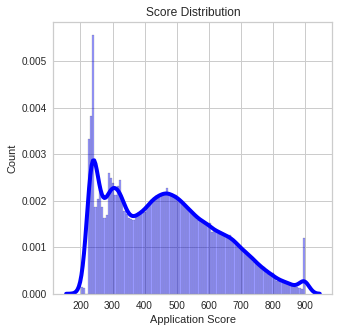

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = sns.distplot(combine_['Risk_Score'], hist=True, kde=True,
                        bins=100, color = 'blue',hist_kws={'edgecolor':'black'},
                         kde_kws={'linewidth': 4})

ax.set_xlabel("Application Score")
ax.set_ylabel("Count")
ax.set_title("Score Distribution")

In [ ]:
Final_data     = pd.concat([df,combine_], axis=1)

In [ ]:
Final_data.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,SeriousDlqin2yrs,Default,Predicted_prob,Risk_Score,Score_decile
0,0.766127,45,2,0.802982,9120.0,13,6,2.0,1,1,0.553273,303.841125,300.000000
1,0.957151,40,0,0.121876,2600.0,4,0,1.0,0,0,0.844106,230.709106,201.368622
2,0.658180,38,1,0.085113,3042.0,2,0,0.0,0,0,0.708846,260.943298,201.368622
3,0.233810,30,0,0.036050,3300.0,5,0,0.0,0,0,0.309555,404.376404,300.000000
4,0.907239,49,1,0.024926,63588.0,7,1,0.0,0,0,0.230026,455.784485,415.000000
